In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [5]:
amazon_df = pd.read_csv("amazon_xm5.csv")
walmart_df = pd.read_csv("walmart_xm5.csv")

conn = sqlite3.connect("reviews.db")

amazon_df.to_sql("amazon_reviews", conn, if_exists="replace", index=False)
walmart_df.to_sql("walmart_reviews", conn, if_exists="replace", index=False)

600

In [6]:
print(amazon_df.columns)
print(walmart_df.columns)

Index(['ASIN', 'Brand', 'HelpfulCounts', 'Images/0', 'Images/1', 'Images/2',
       'Images/3', 'Images/4', 'Images/5', 'Images/6', 'Images/7', 'Images/8',
       'Images/9', 'Images/10', 'Images/11', 'Images/12', 'Images/13',
       'PageUrl', 'ParentId', 'ProductLink', 'ProductTitle', 'ReviewContent',
       'ReviewDate', 'ReviewScore', 'ReviewTitle', 'Reviewer', 'Variant/0',
       'Verified'],
      dtype='object')
Index(['authorId', 'badges/0', 'badges/1', 'badges/2', 'externalSource',
       'itemType', 'negativeFeedback', 'positiveFeedback', 'productId',
       'productName', 'productUrl', 'rating', 'recommended', 'reviewId',
       'submissionTime', 'text', 'title', 'userNickname'],
      dtype='object')


In [7]:
amazon_query = """
SELECT 
    ReviewScore,
    ReviewTitle,
    ReviewContent
FROM amazon_reviews
"""

amazon_selected = pd.read_sql(amazon_query, conn)
amazon_selected.head()

,ReviewScore,ReviewTitle,ReviewContent
0,4.0,Sony xm5 vs bose qc ultra.,"Build QualityFor me, there's no question that ..."
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...
3,5.0,Beautiful and the sound quality is amazing!,I just got these and the sound quality is incr...
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co..."


In [8]:
walmart_query = """
SELECT 
    rating, 
    title,
    text
FROM walmart_reviews
"""

walmart_selected = pd.read_sql(walmart_query, conn)
walmart_selected.head()

,rating,title,text
0,5,Better generation of headphones,Good headphones! Lighter than the previous gen...
1,5,Love the XM5s,I am not sure why I waited so long for these …...
2,5,Awesome Sounds!,"I bought these about a month ago, but we alrea..."
3,5,Flight Changing,Bought the XM5's a few weeks ago in preparatio...
4,5,A Sony convert,It's just over a week since I got these headph...


In [9]:
amazon_selected.rename({"ReviewScore":"rating", "ReviewTitle":"title", "ReviewContent":"text"}, axis=1, inplace=True)

In [10]:
amazon_selected.head()

,rating,title,text
0,4.0,Sony xm5 vs bose qc ultra.,"Build QualityFor me, there's no question that ..."
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...
3,5.0,Beautiful and the sound quality is amazing!,I just got these and the sound quality is incr...
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co..."


In [11]:
combined_df = pd.concat([amazon_selected, walmart_selected], ignore_index=True)
combined_df

,rating,title,text
0,4.0,Sony xm5 vs bose qc ultra.,"Build QualityFor me, there's no question that ..."
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...
3,5.0,Beautiful and the sound quality is amazing!,I just got these and the sound quality is incr...
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co..."
...,...,...,...
897,2.0,Totally inaccurate info from seller.,quality is great but the battery is probably o...
898,5.0,I can say good not excellent,Feature should have optimized more as some tim...
899,5.0,Love these.,Excellent headphones. Love the way it pairs wi...
900,2.0,Major disappointment.,Loved the XM threes but this is not the upgrad...


In [12]:
conn.close()

In [13]:
def combine_text(row):
    title = str(row["title"])
    text = str(row["text"])
    return title + ' ' + text

combined_df['combined_text'] = combined_df.apply(combine_text, axis=1)

combined_df.head()

,rating,title,text,combined_text
0,4.0,Sony xm5 vs bose qc ultra.,"Build QualityFor me, there's no question that ...",Sony xm5 vs bose qc ultra. Build QualityFor me...
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...,Disappointed in build quality The sound qualit...
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...,Design flow with hinge that leads to breakage ...
3,5.0,Beautiful and the sound quality is amazing!,I just got these and the sound quality is incr...,Beautiful and the sound quality is amazing! I ...
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co...","battery life seems low, just software updates ..."


In [14]:
combined_df["combined_text"] = combined_df["combined_text"].replace(r"^\s*$", "[EMPTY]", regex=True)


In [15]:
from langdetect import detect, DetectorFactory

# Set seed for consistent results
DetectorFactory.seed = 42

def detect_language(text):
    try:
        if text.strip():  # Ensure the text is not empty
            return detect(text)
        return "unknown"  # Handle empty strings
    except Exception as e:
        print(f"Error detecting language: {e} - Text: {text}")
        return "error"  # Return "error" if detection fails

In [16]:
# Using langdetect
combined_df["language"] = combined_df["combined_text"].apply(detect_language)

print(combined_df.head())

   rating                                              title  \
0     4.0                         Sony xm5 vs bose qc ultra.   
1     2.0                      Disappointed in build quality   
2     1.0      Design flow with hinge that leads to breakage   
3     5.0        Beautiful and the sound quality is amazing!   
4     5.0  battery life seems low, just software updates ...   

                                                text  \
0  Build QualityFor me, there's no question that ...   
1  The sound quality and noise cancelation was gr...   
2  The issue with the hinge defect is covered ext...   
3  I just got these and the sound quality is incr...   
4  doesn't come with a charger, the cable that co...   

                                       combined_text language  
0  Sony xm5 vs bose qc ultra. Build QualityFor me...       en  
1  Disappointed in build quality The sound qualit...       en  
2  Design flow with hinge that leads to breakage ...       en  
3  Beautiful and the s

In [17]:
combined_df["language"].value_counts()

language
en    891
es      8
af      1
tl      1
ca      1
Name: count, dtype: int64

Notice that only 11 reviews are non english. Given that this is just over 1% of our dataset, rather than translating them I will just drop these reviews (dont want to use the apis)

In [18]:
drop_rows = list(combined_df[combined_df.iloc[:,-1]!="en"].index)
combined_df.drop(combined_df.index[drop_rows], inplace = True)

In [19]:
combined_df

,rating,title,text,combined_text,language
0,4.0,Sony xm5 vs bose qc ultra.,"Build QualityFor me, there's no question that ...",Sony xm5 vs bose qc ultra. Build QualityFor me...,en
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...,Disappointed in build quality The sound qualit...,en
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...,Design flow with hinge that leads to breakage ...,en
3,5.0,Beautiful and the sound quality is amazing!,I just got these and the sound quality is incr...,Beautiful and the sound quality is amazing! I ...,en
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co...","battery life seems low, just software updates ...",en
...,...,...,...,...,...
897,2.0,Totally inaccurate info from seller.,quality is great but the battery is probably o...,Totally inaccurate info from seller. quality i...,en
898,5.0,I can say good not excellent,Feature should have optimized more as some tim...,I can say good not excellent Feature should ha...,en
899,5.0,Love these.,Excellent headphones. Love the way it pairs wi...,Love these. Excellent headphones. Love the way...,en
900,2.0,Major disappointment.,Loved the XM threes but this is not the upgrad...,Major disappointment. Loved the XM threes but ...,en


In [20]:
combined_df.reset_index(drop=True, inplace=True)
combined_df

,rating,title,text,combined_text,language
0,4.0,Sony xm5 vs bose qc ultra.,"Build QualityFor me, there's no question that ...",Sony xm5 vs bose qc ultra. Build QualityFor me...,en
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...,Disappointed in build quality The sound qualit...,en
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...,Design flow with hinge that leads to breakage ...,en
3,5.0,Beautiful and the sound quality is amazing!,I just got these and the sound quality is incr...,Beautiful and the sound quality is amazing! I ...,en
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co...","battery life seems low, just software updates ...",en
...,...,...,...,...,...
886,2.0,Totally inaccurate info from seller.,quality is great but the battery is probably o...,Totally inaccurate info from seller. quality i...,en
887,5.0,I can say good not excellent,Feature should have optimized more as some tim...,I can say good not excellent Feature should ha...,en
888,5.0,Love these.,Excellent headphones. Love the way it pairs wi...,Love these. Excellent headphones. Love the way...,en
889,2.0,Major disappointment.,Loved the XM threes but this is not the upgrad...,Major disappointment. Loved the XM threes but ...,en


[4221, 4406, 4538, 4685, 4718, 4815, 4946, 5238, 5930, 6748] [16, 22, 23, 23, 25, 25, 27, 29, 30, 30]


Text(0, 0.5, 'Count')

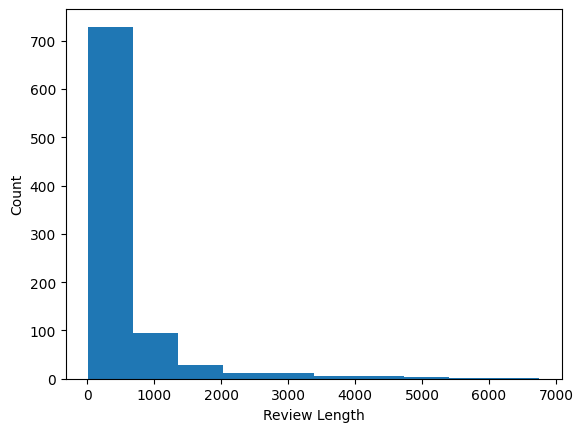

In [21]:
len_reviews_combined = combined_df["combined_text"].str.len()
len_reviews_combined = sorted(len_reviews_combined)
print(len_reviews_combined[-10:], len_reviews_combined[:10])

plt.hist(len_reviews_combined)
plt.xlabel('Review Length')
plt.ylabel('Count')

In [22]:
combined_df["length"] = combined_df["combined_text"].str.len()
shorter_df = combined_df[combined_df["length"] < 500]
shorter_df

,rating,title,text,combined_text,language,length
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...,Disappointed in build quality The sound qualit...,en,190
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...,Design flow with hinge that leads to breakage ...,en,246
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co...","battery life seems low, just software updates ...",en,443
5,1.0,Only lasted 6 months before breaking,"Sound quality is great, but they only lasted 6...",Only lasted 6 months before breaking Sound qua...,en,311
6,5.0,Perfect.,"Better than my Airpods Pros, Better than my Sa...","Perfect. Better than my Airpods Pros, Better t...",en,435
...,...,...,...,...,...,...
886,2.0,Totally inaccurate info from seller.,quality is great but the battery is probably o...,Totally inaccurate info from seller. quality i...,en,154
887,5.0,I can say good not excellent,Feature should have optimized more as some tim...,I can say good not excellent Feature should ha...,en,176
888,5.0,Love these.,Excellent headphones. Love the way it pairs wi...,Love these. Excellent headphones. Love the way...,en,121
889,2.0,Major disappointment.,Loved the XM threes but this is not the upgrad...,Major disappointment. Loved the XM threes but ...,en,145


We're going to split the reviews into positive and negative, so that we can segment the successful purchases while also noting the negative aspects/features. We will consider 3+ stars positive, since 3 stars usually means 'fine' or 'okay' rather than a negative review

In [23]:
positives = shorter_df[shorter_df["rating"] >= 3.0]
positives.reset_index(drop=True, inplace=True)
print(len(positives))
positives.head()

535


,rating,title,text,combined_text,language,length
0,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co...","battery life seems low, just software updates ...",en,443
1,5.0,Perfect.,"Better than my Airpods Pros, Better than my Sa...","Perfect. Better than my Airpods Pros, Better t...",en,435
2,5.0,Perfect headphones,These Sony headphones are EPIC. Sound is great...,Perfect headphones These Sony headphones are E...,en,442
3,5.0,Great noise canceling great sound,The audio quality of these headphones is excep...,Great noise canceling great sound The audio qu...,en,446
4,5.0,The best!!!,"Sony is SONY, no more words.","The best!!! Sony is SONY, no more words.",en,40


In [24]:
negatives = shorter_df[shorter_df["rating"] < 3.0]
negatives.reset_index(drop=True, inplace=True)
print(len(negatives))
negatives.head()

112


,rating,title,text,combined_text,language,length
0,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...,Disappointed in build quality The sound qualit...,en,190
1,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...,Design flow with hinge that leads to breakage ...,en,246
2,1.0,Only lasted 6 months before breaking,"Sound quality is great, but they only lasted 6...",Only lasted 6 months before breaking Sound qua...,en,311
3,1.0,received wrong item in the box and Amazon will...,None,received wrong item in the box and Amazon will...,en,72
4,1.0,NOT NEW!,I received used and dirty headphones in a stai...,NOT NEW! I received used and dirty headphones ...,en,176


## Segmenting the Positive Reviews

In [25]:
print(positives["combined_text"].str.len().max())
print(positives["combined_text"].str.len().min())

497
16


In [26]:
len_reviews = positives["combined_text"].str.len()
len_reviews = sorted(len_reviews)
print(len_reviews[-5:], len_reviews[:5])

[490, 491, 494, 495, 497] [16, 22, 23, 23, 25]


Text(0, 0.5, 'Count')

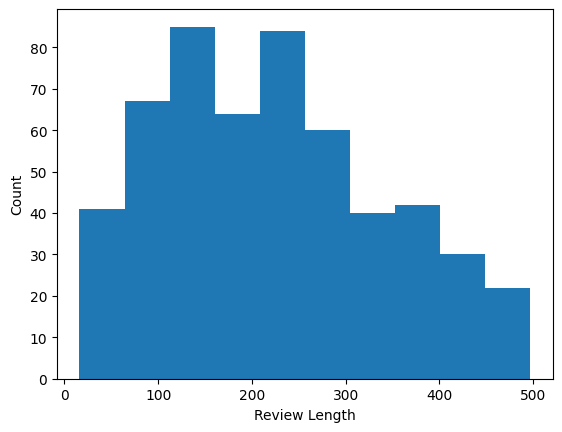

In [27]:
plt.hist(len_reviews)
plt.xlabel('Review Length')
plt.ylabel('Count')

Notice that most of our documents/texts are under 1000 characters (before preprocessing and text cleaning). Methods like PCA may lose valuable information from the text.

In [28]:
import re
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Define custom stopwords
custom_stopwords = list(text.ENGLISH_STOP_WORDS) + ["headphones", "sony", "product", "review", "bose", "sennheiser", "xm", "xms",
                                                    "amazon", "earbuds", "earphones", "use", "using", "item", "music",
                                                    "airpods", "airpod", "beats", "bowers wilkins", "jbl", "xm3", "xm3s",
                                                    "xm4", "xm4s", "bowers", "wilkins", "good", "packaging", "package", "sound",
                                                    "qc", "50", "sound", "oder", "deliver"]


tfidf = TfidfVectorizer(
    stop_words=custom_stopwords,
    max_features=6000,
    ngram_range=(1, 3),  # Capture unigrams and bigrams
    use_idf=True,
)

# Apply TF-IDF to your tokenized text
tfidf_matrix = tfidf.fit_transform(combined_df["combined_text"])

svd = TruncatedSVD(n_components=200, random_state=42)

reduced_matrix = svd.fit_transform(tfidf_matrix)

print(f"Shape of reduced matrix: {reduced_matrix.shape}")


Shape of reduced matrix: (891, 200)


In [29]:
var_explained = svd.explained_variance_ratio_.sum()
var_explained

np.float64(0.5379058887219053)

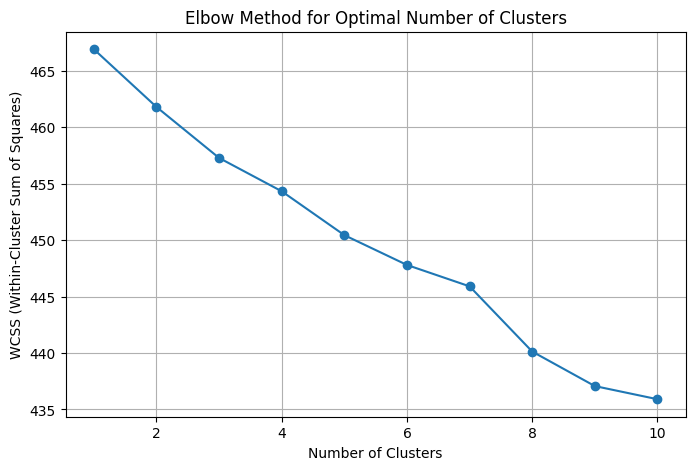

In [30]:
from sklearn.cluster import KMeans

# Step 1: Iterate over a range of cluster numbers
wcss = []
range_clusters = range(1, 11)  # Test from 1 to 10 clusters

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_matrix)
    wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances to nearest cluster center

# Step 2: Plot the WCSS values
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

Using the elbow method and many iterations of hyperparams for vectorization and svd, we can see that the data does not clusters properly into any # of clusters (no elbow). To find segments, we will use the predetermined cluster of star rating to find topics that are positive, and some which are good but can use improvement (3 stars).

## Positive Reviews

In [68]:
reviews_3 = positives[positives["rating"] == 3]["combined_text"]
reviews_4 = positives[positives["rating"] == 4]["combined_text"]
reviews_5 = positives[positives["rating"] == 5]["combined_text"]

In [69]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())  # Remove non-alphabetic characters
    tokens = text.split()
    return " ".join([lemmatizer.lemmatize(word) for word in tokens if word not in custom_stopwords])

reviews_3 = reviews_3.apply(clean_text)
reviews_4 = reviews_4.apply(clean_text)
reviews_5 = reviews_5.apply(clean_text)

In [70]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=3500, stop_words=custom_stopwords, ngram_range=(1,3))
matrix_3 = vectorizer.fit_transform(reviews_3)
matrix_4 = vectorizer.fit_transform(reviews_4)
matrix_5 = vectorizer.fit_transform(reviews_5)


In [71]:
from sklearn.decomposition import LatentDirichletAllocation

lda_3 = LatentDirichletAllocation(n_components=6, random_state=42)  # Adjust topics
lda_3.fit(matrix_3)

lda_4 = LatentDirichletAllocation(n_components=6, random_state=42)
lda_4.fit(matrix_4)

lda_5 = LatentDirichletAllocation(n_components=6, random_state=42)
lda_5.fit(matrix_5)


LatentDirichletAllocation(n_components=6, random_state=42)

In [72]:
def print_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[-n_top_words:]]))

print("3-Star Topics:")
print_topics(lda_3, vectorizer.get_feature_names_out())


3-Star Topics:
Topic 0:
discount cheaper, dont cut plane, dont come close, discount, dont cut, abit blurry, desired profile straight, company prized, best ive purchased, background noise
Topic 1:
company prized, customisation, day best varmint, comfort noise, excellent upgrade, class, doesnt know, db, background noise, day ahead
Topic 2:
company prized, awesome forget, especially noisecancellation ability, equalization, connectivity great, amazing, experienced compared, design surprised fast, crisp comfortable, delivers
Topic 3:
comfort best noisecancelling, best great, close professional ear, distraction busy, did adjust, different theyre light, comfortable long lasting, device work, connect device seamless, crisp comfortable
Topic 4:
experienced compared, delivers, downside bit pricey, clear step quality, clear easy, ago durability faux, especially equalizer, connect device seamless, dont pas, company prized
Topic 5:
coming listen home, close professional ear, doesnt know, design doe

In [75]:
print_topics(lda_4, vectorizer.get_feature_names_out())

Topic 0:
doing anymore, moving impeccable, honest, amazing ambient mode, help, exceptional bought, carry protected, great overall, excellent upgrade, day best
Topic 1:
connected, design surprised fast, come block majority, confirmed promised, player love, noise anc, exceptionally, changer aware week, day best, excellent upgrade
Topic 2:
equalizer week im, bulky, great overall, equalizer week, active noise cancellation, covering right, changer aware week, exceptionally, excellent upgrade, day best
Topic 3:
bought, delivering rich bass, fantastic honest prefer, come block majority, connected, day best, lineup fixed, noise anc, amazing ambient mode, great overall
Topic 4:
compare, confirmed promised, dirty, ear, best soundingas, best sounding wireless, great overall, comfortably quality amazing, ear monitor ive, day best
Topic 5:
comfortable easily comparable, completely comfortable, clarity, come block majority, easy understand, compare, quality battery, ambient mode, day best, great ove

In [76]:
print_topics(lda_5, vectorizer.get_feature_names_out())

Topic 0:
ago, price, wear, excellent, better, comfortable, best, great, noise, quality
Topic 1:
price, best, love, bought, work, feature, better, noise, quality, great
Topic 2:
happy, excellent, amazing, feature, noise cancelling, cancelling, love, noise, great, quality
Topic 3:
app, canceling, love, really, bought, quality, noise, amazing, great, best
Topic 4:
cancellation, ive, quality, comfortable, excellent, best, great, noise cancelling, cancelling, noise
Topic 5:
work, best, cancelling, noise cancelling, comfortable, quality, amazing, ive, noise, great


### Insights

### 3-star reviews
The 3-star topics comment on the comfort of the headphones, and how they fit. There are also mentions of daily use, some mentions of the sound quality, and of the connectivity. Overall, these reviews show that the positive aspects of the headphones for somewhat satisfied buyers seem to be the comfort and the adequate sound quailty. Many of the negative sentiment topics are related to price, or buying it on sale/discount. 

The 3-star reviews indicate customers value seamless connectivity and comfort but have mixed feelings about pricing, customization options, and value for the price point.

#### Customer Persona - The Practical Commuter

Profile: Commuters and everyday users who appreciate seamless connectivity, comfort, and decent sound quality.
Needs: Reliable and easy-to-use headphones for daily activities.
Frustrations: High price and challenges with advanced customization options.
Motivations: A reliable, straightforward product that performs consistently in their daily routine.

### 4-star reviews
The 4-star topics highlight satisfaction with features like noise cancellation, and sound quality. Customers frequently mention the comfort of the headphones and the ambient mode for everyday use. Noise cancellation (ANC) is a prominent positive feature, along with battery life and ease of connectivity. However, there are minor mentions of bulkiness and comparisons to earlier models, indicating expectations for further improvements. Price is less of a concern in these reviews compared to 3-star reviews, but some customers still mention value for the cost.

The 4-star reviews suggest customers value active noise cancellation, and ambient mode while expecting small refinements in usability and design.

#### Customer Persona - The Enthusiastic Upgrader
Profile: Users upgrading from older models or competing products who value ANC, sound quality, and comfort for daily use.
Needs: Reliable noise cancellation, superior sound quality, and all-day comfort for work, commuting, or leisure.
Frustrations: Minor dissatisfaction with design improvements or bulkiness.
Motivations: High-quality features that enhance their everyday routine and justify the upgrade.

### 5-star reviews
The 5-star topics overwhelmingly praise the noise cancellation, comfort, and sound quality of the headphones. Many customers describe the product as "excellent," "amazing," and "worth it." Words like "happy" and "love" dominate, indicating a high level of satisfaction. Comfort and ANC are repeatedly mentioned as standout features, with little to no frustration expressed. These reviews suggest that customers in this category perceive the headphones as premium and well worth the price.

The 5-star reviews emphasize customer satisfaction with premium features like noise cancellation, comfort, and sound quality, with minimal mentions of negative aspects.

#### Customer Persona - The Loyal Audiophile
Profile: Highly satisfied, loyal customers who value premium features and top-tier sound quality.
Needs: Superior noise cancellation, comfort for extended wear, and premium sound quality for an immersive listening experience.
Frustrations: None or negligible; these customers are fully satisfied with their purchase.
Motivations: A desire for top-tier performance and premium experiences that exceed expectations.




## Negative Reviews

Lets try to use Kmeans to see if there are any clusters. If the negative data does not cluster cleanly, we will use the same method (LDA Topic Modelling) to figure out patterns among the negative reviews as well

In [55]:
# Define custom stopwords
custom_stopwords = list(text.ENGLISH_STOP_WORDS) + ["headphones", "sony", "product", "review", "bose", "sennheiser", "xm", "xms",
                                                    "amazon", "earbuds", "earphones", "use", "using", "item", "music",
                                                    "airpods", "airpod", "beats", "bowers wilkins", "jbl", "xm3", "xm3s",
                                                    "xm4", "xm4s", "bowers", "wilkins", "good", "packaging", "package", "sound",
                                                    "qc", "50", "sound", "oder", "deliver"]


tfidf = TfidfVectorizer(
    stop_words=custom_stopwords,
    max_features=900,
    ngram_range=(1, 3),  # Capture unigrams and bigrams
    use_idf=True,
)

# Apply TF-IDF to your tokenized text
tfidf_matrix_negatives = tfidf.fit_transform(negatives["combined_text"])

svd = TruncatedSVD(n_components=60, random_state=42)

reduced_matrix_negatives = svd.fit_transform(tfidf_matrix_negatives)

print(f"Shape of reduced matrix: {reduced_matrix.shape}")


Shape of reduced matrix: (112, 112)


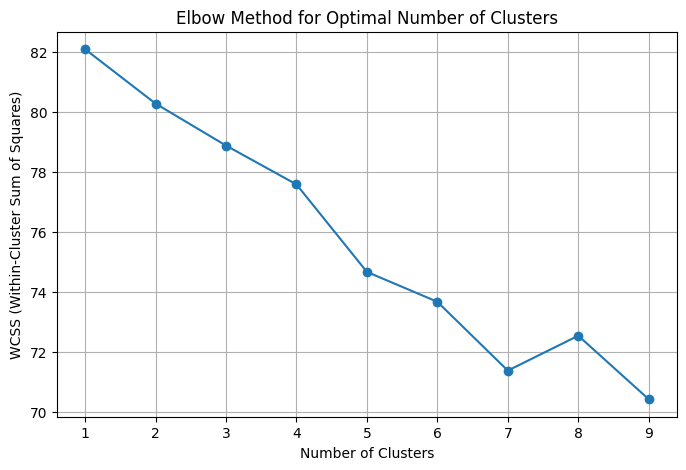

In [56]:
wcss_negatives = []
range_clusters_n = range(1, 10)

for k in range_clusters_n:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_matrix_negatives)
    wcss_negatives.append(kmeans.inertia_)  # Inertia: Sum of squared distances to nearest cluster center

# Step 2: Plot the WCSS values
plt.figure(figsize=(8, 5))
plt.plot(range_clusters_n, wcss_negatives, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

Unfortunately Kmeans looks unreasonable even with different hyperparams. This seems to be the problem with smaller datasets, as we cannot train custom embedding models on our data, and there is not enough variance. Nonetheless, this is just to learn a skill and work on a real-world (smaller scale) task that I may be assigned with. Also it's still pretty fun working with, and trying out different tools and seeing the results (or lack thereof) right in front of you